# Counting Stars (V4)

In [422]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import pylab

from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.utils.data import download_file
imgFile = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True)

hdulist = fits.open(imgFile)
img = hdulist[0].data

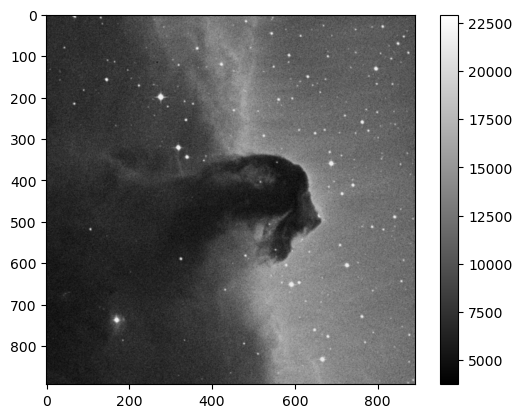

In [423]:
plt.imshow(img, cmap='gray')
plt.colorbar()

# Annulus

**Todo**:
- Investigate different background and circular aperture sizes

In [424]:
from PIL import Image
im_frame = Image.open('/home/saphio/Downloads/annulus_21.png')

In [425]:
np_frame = np.array(im_frame)
annulus_size = len(np_frame)

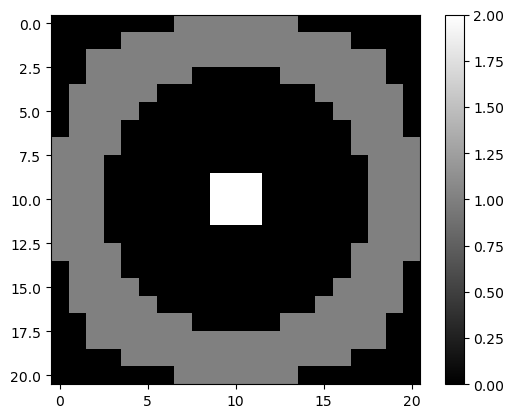

In [426]:
## Fixing up imported annulus

annulus = np.zeros((annulus_size, annulus_size))
for i in range(len(np_frame)):
    for j in range(len(np_frame[0])):
        if (np_frame[i, j, 0] == 0 and np_frame[i, j, 3] == 255):
            annulus[i, j] = 1 ## background
        elif (np_frame[i, j, 0] == 112):
            annulus[i, j] = 2 ## star

plt.imshow(annulus, cmap='gray')
plt.colorbar()

# Signal to Noise Ratio Function

In [427]:
def calculate_ratio (testImg, x, y):
    ## Summing counts

    circle_counts = 0
    annulus_counts = 0
    
    circle_pixels = 0
    annulus_pixels = 0

    for i in range(annulus_size):
        for j in range(annulus_size):
            try:
                if (annulus[i, j] == 2):
                    circle_counts += testImg[i + x, j + y]
                    circle_pixels += 1
                elif (annulus[i, j] == 1):
                    annulus_counts += testImg[i + x, j + y]
                    annulus_pixels += 1
            except:
                pass
                
    # Sky background per Pixel (N_s)
    sky_bg_pixel = annulus_counts / annulus_pixels

    # Signal in Aperture (N_T)
    signal = (circle_counts - (circle_pixels * annulus_counts / annulus_pixels))
    
    # Total noise = sqrt(N_T + N_s * npix + other stuff (dark current, readout))
    total_noise = np.sqrt(signal + (circle_pixels * annulus_counts / annulus_pixels))
    
    if (total_noise == 0):
        total_noise = 0.01
    
    return signal/total_noise

# Threshold Investigation
**Todo**:
- Fit gaussian distribution on histogram output 
    - determine how well it fits the histogram
- Determine how to best find the threshold
    - idea 1: estimate 3 SD to 5 SD away from the mean
    - idea 2: noise is gaussian, signal is not; things that don't fit the gaussian distribution are the signal (look at outliers)
    - idea 3: just explore different thresholds, could use binary search method to speed up the process

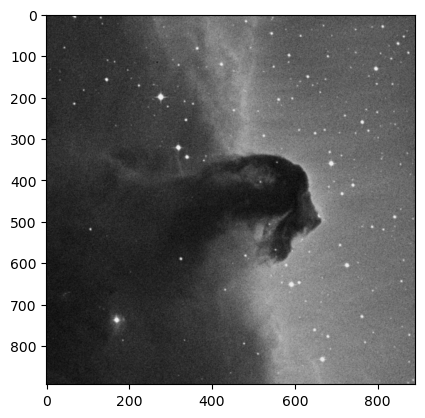

In [428]:
testImg = img
plt.imshow(testImg, cmap='gray', vmin=3759, vmax=22918)

In [429]:
snrImg = np.zeros(testImg.shape)
offset = int((annulus_size + 1)/2)
for i in range(-offset, len(testImg) - offset):
    for j in range(-offset, len(testImg[0]) - offset):
        snrImg[i + offset, j + offset] = calculate_ratio(testImg, i, j)

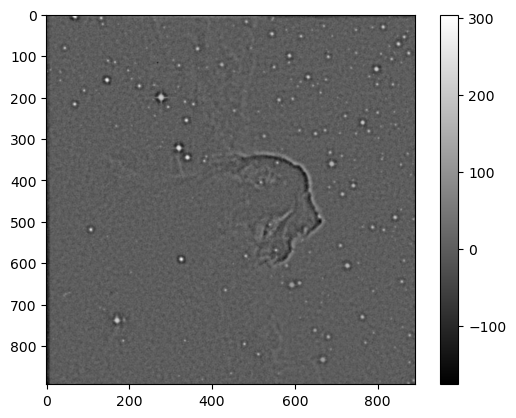

In [430]:
plt.imshow(snrImg, cmap='gray')
plt.colorbar()

In [431]:
snrData = snrImg.flatten()

amp 32046.760475351126 
mean -0.8316513508642388 
sigma 11.292580460520329


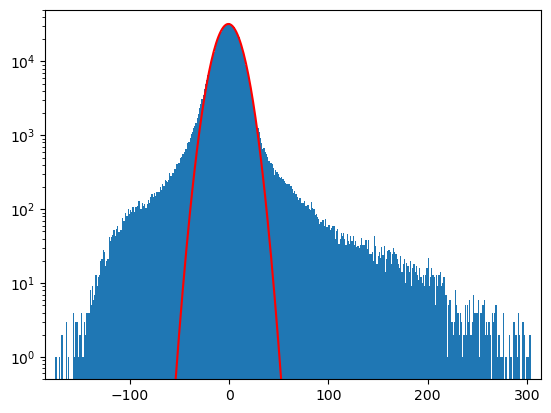

In [432]:
## histogram
n, bins, _ = plt.hist(snrData, bins=400, log=True)

## fitting gaussian curve
def gaussian (x, a, mean, sigma):
    return a * np.exp(-((x-mean)**2)/(2*sigma**2))

x = np.linspace(min(snrData), max(snrData), 400)
y = n

popt, pcov = curve_fit(gaussian, x, y)
plt.plot(x, gaussian(x, *popt), c='r')

plt.axis([min(snrData) - 10, max(snrData) + 10, 0.5, 50000])

## fit parameters
print('amp', popt[0], '\nmean', popt[1], '\nsigma', popt[2])
amp, mean, stdev = popt

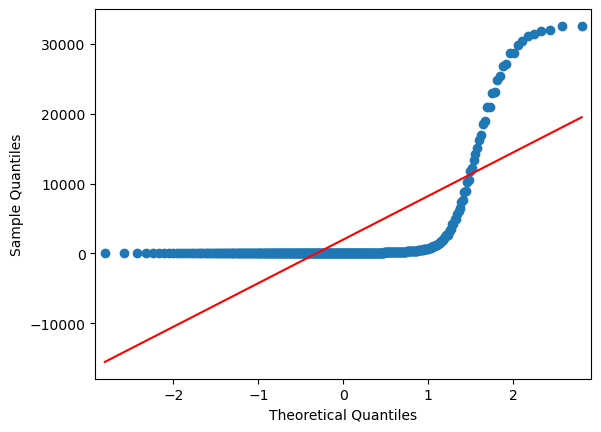

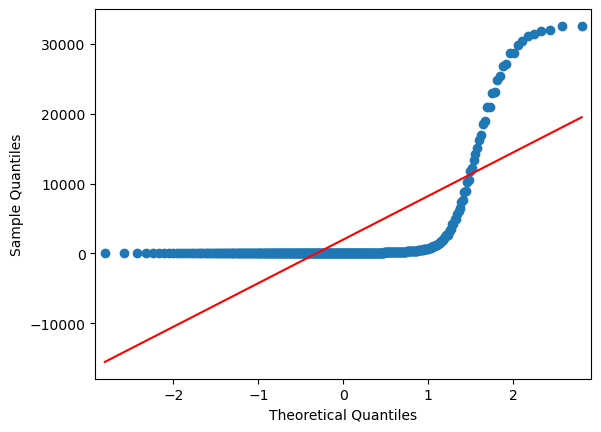

In [433]:
sm.qqplot(n, stats.norm, line='s')

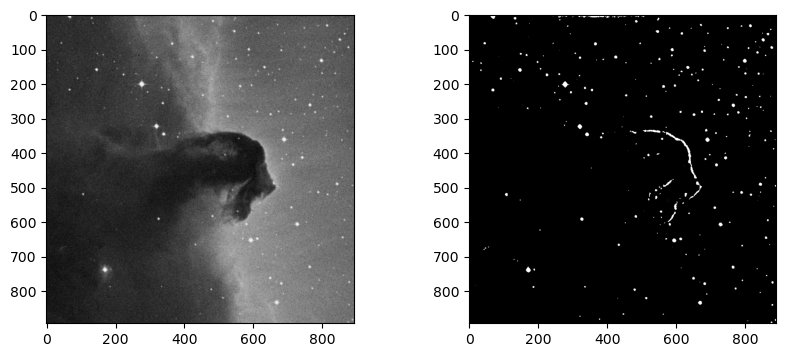

In [434]:
threshold = mean + 4.5 * stdev

## apply threshold on testImg
imgCut = np.zeros(snrImg.shape)

for i in range(len(snrImg)):
    for j in range(len(snrImg[0])):
        if (snrImg[i, j] >= threshold):
            imgCut[i, j] = 100
        else:
            imgCut[i, j] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axes[0].imshow(testImg, cmap='gray')
axes[1].imshow(imgCut, cmap='gray')

# Counting the Stars

In [435]:
def neighbor (matrix, i, j):
    try:
        if (matrix[i - 1][j - 2] or
            matrix[i - 1][j - 1] or
            matrix[i - 1][j] or
            matrix[i - 1][j + 1] or
            matrix[i - 1][j + 2] or
            matrix[i][j - 1]):
            return 0
        else:
            return 1
    except:
        return -1

In [436]:
matrix = [[False for i in range(len(img[0]))] for j in range(len(img))]

count = 0

for i in range(len(imgCut)):
    for j in range(len(imgCut[0])):
        if (imgCut[i, j] == 100):
            matrix[i][j] = True
            if (neighbor(matrix, i, j) == 1):
                count += 1
        else:
            matrix[i][j] = False

In [437]:
count

294